# Getting started

We'll first create a new pizza ontology using a resolvable W3ID that will be provided through the Ontostart project - https://github.com/micheldumontier/ontostart.

In [1]:
from lib.helpers import *

# Create our pizza ontology and import SULO
base_iri = "https://w3id.org/ontostart/pizza/"
pizza = get_ontology(base_iri)

Next, we'll import the SULO ontology into the pizza ontology, so we can use SULO's classes and properties in our definitions.

In [2]:
sulo = get_ontology("https://w3id.org/sulo/sulo.owl").load()  # RDF/XML
print("Loaded SULO:", sulo.base_iri)
pizza.imported_ontologies.append(sulo)

Loaded SULO: https://w3id.org/sulo/


# The nature and composition of a pizza

Let's think about the nature and composition of a pizza. A **pizza** is traditionally a dish of Italian origin, consisting of a flat round base of baked dough (aka **pizza crust** or **pizza base**) that may be covered with a tomato-based sauce, and optionally with herbs, cheese, meat, fish, and/or vegetables. 

We formally represent **Pizza**, **Pizza Crust**, **Pizza Sauce**, and **Pizza Topping** as **Classes** in OWL - that is to say, they represent a set of individuals having a set of shared attributes. **Classess** differ from **Individuals** in that **Individuals** cannot be instantiated - there is only one of them. For instance, the meat-containing pizza on my table is an **Individual**, while the set of all meat-containing pizzas is a **Class**. 

Using owlready2, we declare our first set of classes.

In [3]:
# let's start with a top level category called FoodProduct to define a pizza and its parts
with pizza:
    class Pizza(Thing):
        comment = """A pizza is a food material minimally consisting of a pizza crust (baked dough) and optionally topped with tomatoes or tomato sauce, cheese, and often various other ingredients (such as anchovies, mushrooms, onions, olives, vegetables, meat, etc.) baked at a high temperature."""

    class PizzaCrust(Thing):
        comment = """A pizza crust is a food material resulting from the cooking of a dough and forms the base of a pizza upon which sauce and toppings are added."""

    class PizzaSauce(Thing):
        comment = """A pizza sauce is a food material used in the preparation of pizza, typically made from tomatoes and various herbs and spices."""

    class PizzaTopping(Thing):
        comment = """A pizza topping is a food material that is placed on top of a pizza, such as cheese, vegetables, meats, or other ingredients."""

**Pizza**, **Pizza Crust**, **Pizza Sauce**, and **Pizza Topping** are all kinds of **Food Material**, and all of these are kinds of SULO's **Spatial Objects**. They are objects that persist in time, can gain and lose parts, change qualities, and are wholly identifiable at point in their lifetime. 

To capture this relationship, we define a **subclass axiom** in the Ontology to expresses that every instance of one class is necessarily an instance of another. 

In [4]:
with pizza:
    # declaring FoodMaterial as a subclass of sulo.SpatialObject
    class FoodMaterial(sulo.SpatialObject):
        pass
    
    # adding FoodMaterial as a superclass of Pizza, PizzaCrust, PizzaSauce, and PizzaTopping
    PizzaCrust.is_a.append(FoodMaterial)
    PizzaSauce.is_a.append(FoodMaterial)
    PizzaTopping.is_a.append(FoodMaterial)

Let's add a description of **Pizza** as a **Food Material** that has a **Pizza Crust** as a part.

**hasPart** expresses a mereological connection between a whole and its integral components - it defines what something is made of. When we say that a **Pizza** **hasPart** **Pizza Sauce**, we mean the sauce is a constitutive part of the pizza’s material structure; removing it would change the pizza itself. In contrast, **contains** describes a spatial or topological relation of inclusion, where one object occupies space within another but remains independent of it. For example, an oven contains a pizza while baking, or a pizza box contains a pizza during delivery, but neither the oven nor the box becomes part of the pizza. Thus, **hasPart** is transitive, compositional, and identity-defining, while **contains** is contextual, spatial, and non-constitutive—one relates to structure, the other to location.

We now want to formalise the relation between a **Pizza** and its constitutive parts, for instance, the **Pizza Crust**. **Subclass axioms with cardinality restrictions** are ideal for representing compositional constraints. These indicate how many such relations must hold true for something qualify as a member of this class. T

In our example, we want to say that every instance of a **Pizza** must have exactly one **Pizza Crust** as a part. This makes sense because there can be no pizza without a crust, and it doesn't make sense to have more than one crust for a single pizza.

In [5]:
with pizza:
    Pizza.is_a.append(sulo.hasPart.exactly(1, PizzaCrust))

Next, let's run the automated reasoner to make sure that our ontology is consistent.

In [6]:
ret = safe_call_reasoner(pizza)
if not ret["ok"]:
    print("Reasoner Error: \n", ret["error"])



Reasoner Error: 
 Non-simple property '<https://w3id.org/sulo/hasPart>' or its inverse appears in the cardinality restriction 'ObjectMaxCardinality(1 <https://w3id.org/sulo/hasPart> <https://w3id.org/ontostart/pizza/PizzaCrust>)'.


Well, we see that we get an error from the reasoner, namely that 

```Non-simple property '<https://w3id.org/sulo/hasPart>' or its inverse appears in the cardinality restriction 'ObjectMaxCardinality(1 <https://w3id.org/sulo/hasPart> owl:Thing)'.```

OWL is a reasonably expressive language that places some constraints to ensure decidability (that an answer of yes or no can be provided in a reasonable time). One of those restrictions is that you can't place a cardinality restriction on a transitive property - in this case, we can't put the restriction of exactly 1 on **hasPart**. SULO knew you'd want to do this, and therefore has introduced a sub-property called **hasDirectPart**, which is not transitive, and for which you can place the cardinality restriction. 

Let's now remove the problematic axioms and replace **hasPart** with **hasDirectPart**.

In [7]:
with pizza:
    destroy_entity(Pizza) # remove the class Pizza
    
    class Pizza(FoodMaterial):
        comment = """A pizza is a food material minimally consisting of a pizza crust (baked dough) and optionally topped with tomatoes or tomato sauce, cheese, and often various other ingredients (such as anchovies, mushrooms, onions, olives, vegetables, meat, etc.) baked at a high temperature."""
        is_a = [sulo.hasDirectPart.exactly(1, PizzaCrust)]

In [8]:
results = safe_call_reasoner(pizza)
print("Pizza ontology has", len(results["inconsistent"]), "inconsistent classes")

Pizza ontology has 0 inconsistent classes


Great, the ontology is consistent. 

As **hasDirectPart** is a sub-property of **hasPart**, we should be able to query the ontology to retrieve the parts of a pizza. 

Using owlready2, we prefix the relation with INDIRECT_ to get the inferred relation.

In [9]:
Pizza.INDIRECT_hasPart

[pizza.PizzaCrust]

Having defined the compositional requirements of a Pizza, we can extend our ontology to capture different kinds of pizzas. 

Let us consider the Four Cheese pizza, which is traditionally made from Mozzarella, Gorgonzola, Parmesan, and Pecorino Romano, but other cheeses could also be used.

We will first define the class of Cheese, and then define our Four Cheese Pizza as a Pizza that exactly contains 4 (different) Cheeses.

In [10]:
with pizza:
    class Cheese(FoodMaterial):
        comment = """A cheese is a food material derived from milk and produced in a wide range of flavors, textures, and forms by coagulation of the milk protein casein."""
    
    class Mozzarella(Cheese):
        comment = """Mozzarella is a traditionally southern Italian cheese made from Italian buffalo's milk by the pasta filata method."""
        
    class Gorgonzola(Cheese):
        comment = """Gorgonzola is a veined Italian blue cheese, made from unskimmed cow's milk."""
    
    class Parmesan(Cheese):
        comment = """Parmesan is a hard, granular cheese named after the producing areas near Parma, Italy."""
        
    class PecorinoRomano(Cheese):
        comment = """Pecorino Romano is a hard, salty Italian cheese, often used for grating, made out of sheep's milk."""
    
    class TraditionalFourCheesePizza(Pizza):
        comment = """A Traditional Four Cheese Pizza is a pizza made with mozzarella, gorgonzola, parmesan, and pecorino romano."""
        equivalent_to = [Pizza
                         & sulo.hasDirectPart.exactly(1, Mozzarella)
                         & sulo.hasDirectPart.exactly(1, Gorgonzola)
                         & sulo.hasDirectPart.exactly(1, Parmesan)
                         & sulo.hasDirectPart.exactly(1, PecorinoRomano)]

    class FourCheesePizza(Pizza):
        comment = """A Four Cheese Pizza is a pizza that contains exactly four different types of cheese as toppings."""
        equivalent_to = [Pizza & sulo.hasDirectPart.exactly(4, Cheese)]


In [11]:
in_ancestors(pizza, TraditionalFourCheesePizza, FourCheesePizza) 

TraditionalFourCheesePizza is NOT a subclass of FourCheesePizza


Ok, we were expecting that our traditional four cheese pizza is a four cheese pizza, but we don't find this. The reason is that the reasoner does not know that the four cheeses (Mozzarella, Gorgonzola, Parmesan, Pecorino) are actually different. This behaviour is known as the **Open World Assumption**. That is to say, the reasoner does not assume that things are different (or the same) unless otherwise indicated (either explicitly or by inference). 

To indicate that the four cheeses are in fact different from one another, we have to do two things:
1. use the **AllDisjoint** axioms to indicate that each class is different such that no individual that can be a member of any two in the set.
2. indicate that the traditional four cheese pizza is composed of the four cheeses and the crust and no other thing. This is done with a **Universal Cardinality Restriction**

In [12]:
with pizza:
    AllDisjoint([Mozzarella, Gorgonzola, Parmesan, PecorinoRomano])

    destroy_entity(TraditionalFourCheesePizza) # remove the class TraditionalFourCheesePizza
    class TraditionalFourCheesePizza(Pizza):
        comment = """A Four Cheese Pizza is a pizza that contains exactly four different types of cheese as toppings."""
    
        equivalent_to = [Pizza
                        & sulo.hasDirectPart.exactly(1, Mozzarella)
                        & sulo.hasDirectPart.exactly(1, Gorgonzola)
                        & sulo.hasDirectPart.exactly(1, Parmesan)
                        & sulo.hasDirectPart.exactly(1, PecorinoRomano)
                        & sulo.hasDirectPart.only(OneOf([Mozzarella, Gorgonzola, Parmesan, PecorinoRomano]))
                        ]

In [13]:
in_ancestors(pizza, TraditionalFourCheesePizza, FourCheesePizza) 

TraditionalFourCheesePizza is a subclass of FourCheesePizza


Let's save our pizza ontology.

In [14]:
pizza.save(file = "pizza.owl", format = "rdfxml")

Pizza Class hierarchy


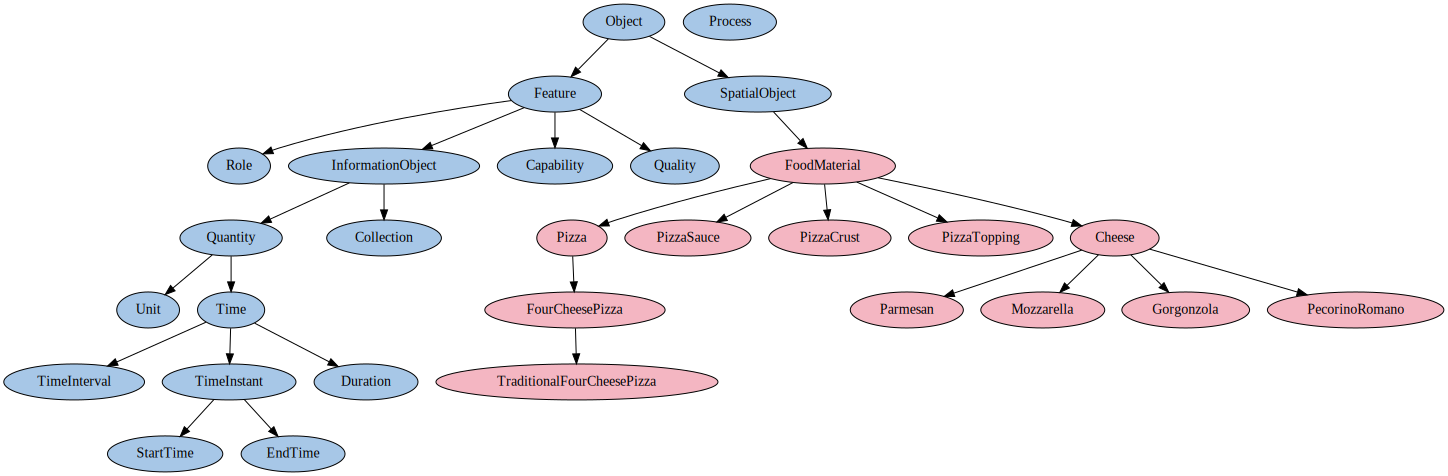

In [17]:
pizza_class_tree = get_color_tree([sulo, pizza])
print("Pizza Class hierarchy")
display(pizza_class_tree)  # Class hierarchy